In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from scipy.stats import uniform,norm
import matplotlib.pyplot as plt
import scipy.stats as sct
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.cluster import KMeans
from skimage import morphology

from skimage.draw import polygon

In [2]:
def read_structure(structure):
    contours = []
    for i in range(len(structure.ROIContourSequence)):
        contour = {}
        contour['color'] = structure.ROIContourSequence[i].ROIDisplayColor
        contour['number'] = structure.ROIContourSequence[i].ReferencedROINumber ##
        contour['name'] = structure.StructureSetROISequence[i].ROIName
        assert contour['number'] == structure.StructureSetROISequence[i].ROINumber
        contour['contours'] = [s.ContourData for s in structure.ROIContourSequence[i].ContourSequence]
        contours.append(contour)
    return contours

def get_mask(contours, slices):
    z = [round(s.ImagePositionPatient[2],1) for s in slices] ##
    #print(z)
    pos_r = slices[0].ImagePositionPatient[1]
    spacing_r = slices[0].PixelSpacing[1]
    pos_c = slices[0].ImagePositionPatient[0]
    spacing_c = slices[0].PixelSpacing[0]

    label = np.zeros_like(image, dtype=np.uint8)
    for con in contours:
        num = int(con['number'])
        for c in con['contours']:
            nodes = np.array(c).reshape((-1, 3)) #triplets describing points of contour
            assert np.amax(np.abs(np.diff(nodes[:, 2]))) == 0
            z_index = z.index(np.around(nodes[0, 2], 1))
            #print(np.around(nodes[0, 2], 1))
            r = (nodes[:, 1] - pos_r) / spacing_r
            c = (nodes[:, 0] - pos_c) / spacing_c
            rr, cc = polygon(r, c)
            label[rr, cc, z_index] = num

        colors = tuple(np.array([con['color'] for con in contours]) / 255.0)
    return label, colors

In [3]:
contour_path="1.000000-RS Unapproved Structure Set-42179/1-1.dcm"
img_path="3.000000-T2 TSE-50580"

In [4]:
#read img and contour
contour=pydicom.read_file(contour_path)
contours=read_structure(contour)
slices = [pydicom.read_file(img_path + '/' + s) for s in os.listdir(img_path)]
image = np.stack([s.pixel_array for s in slices], axis=-1)
label, colors = get_mask(contours, slices)

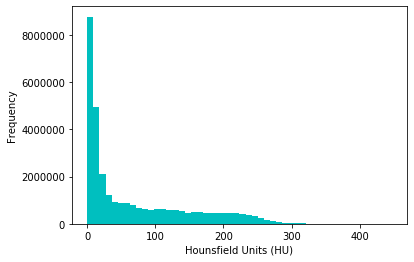

In [5]:
plt.hist(image.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [6]:
print("Slice Thickness: %f" % slices[8].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (slices[8].PixelSpacing[0], slices[8].PixelSpacing[1]))

Slice Thickness: 2.000000
Pixel Spacing (row, col): (0.500000, 0.500000) 


(-0.5, 511.5, 511.5, -0.5)

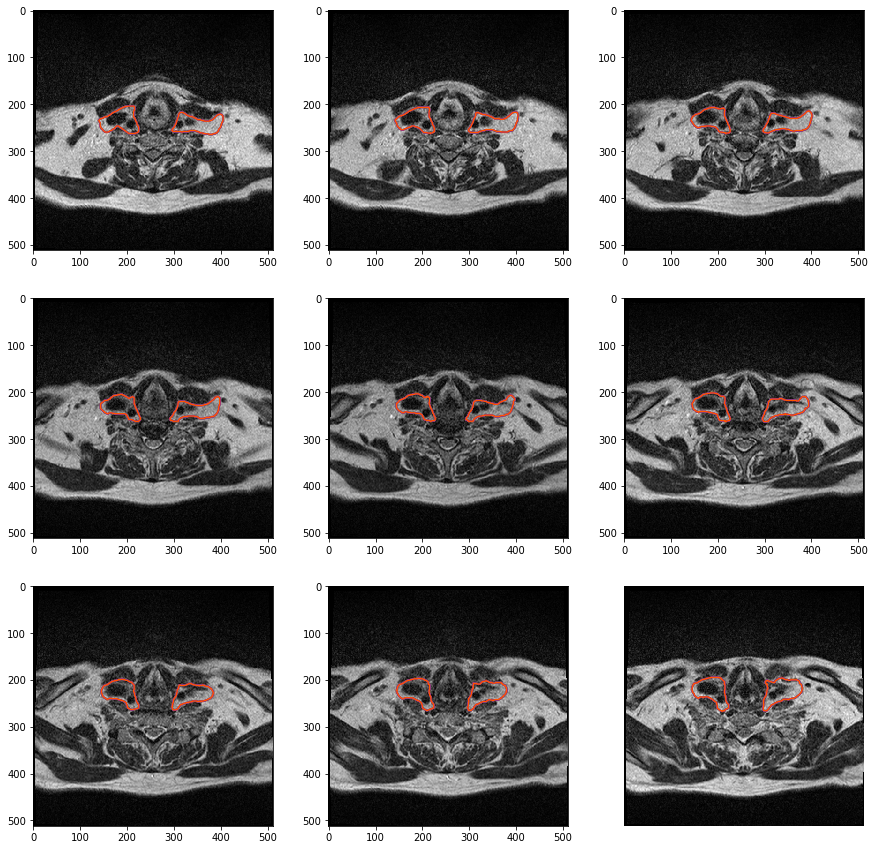

In [7]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image[..., i + 75 ], cmap="gray")
    plt.contour(label[..., i + 75 ], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors=colors)
plt.axis('off')

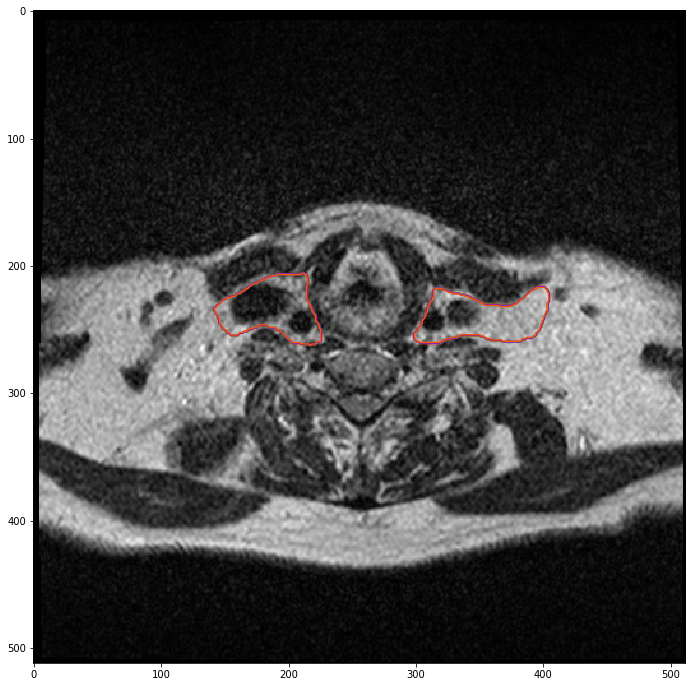

In [8]:
target_img = image[..., 76]
target_label = label[..., 76]
fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(target_img, cmap="gray")
plt.contour(target_label, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors=colors)
plt.show()

In [9]:
np.unique(target_label)

array([0, 5, 6], dtype=uint8)

In [10]:
row_size = target_label.shape[0]
col_size = target_label.shape[1]

#for N in good_labels:
n_mask=np.unique(target_label)
mask=0
for i in n_mask:
    mask_i=np.where(target_label==i,i,0)
    mask = mask + mask_i
interior=morphology.erosion(mask,np.ones([3,3])) # one last dilation 
#interior=morphology.erosion(mask,np.ones([5,5])) # o
contour = np.where(interior==0, 1, 0)
surface = contour*mask

In [11]:
np.where(interior!=0)

(array([208, 208, 208, ..., 260, 260, 260], dtype=int64),
 array([192, 193, 194, ..., 218, 219, 220], dtype=int64))

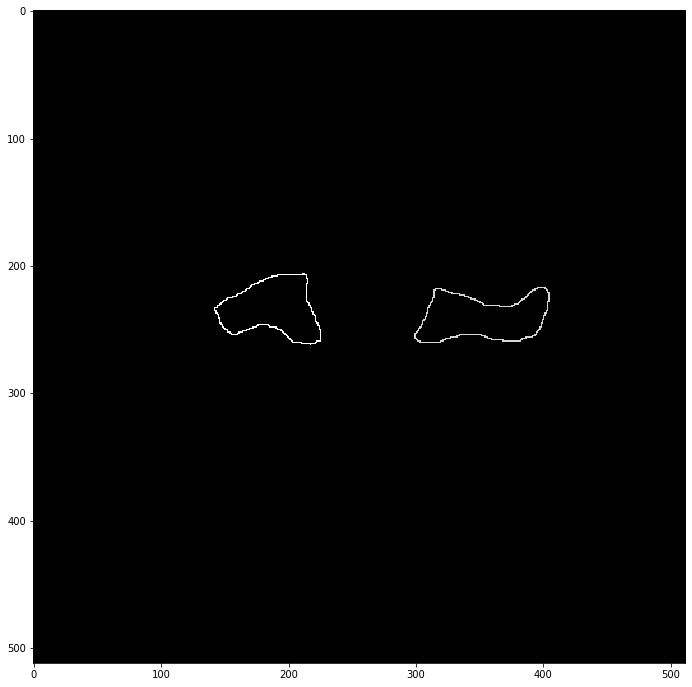

In [12]:
fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(surface, cmap="gray")
plt.show()

In [13]:
def search(vector, r, i, pos_neighbor, neg_neighbor, pos_current_distance, neg_current_distance):
    if vector[i] != 0:   
        if i-r > 0:
            if i-r < min(pos_current_distance):
                pos_current_distance.append(i-r)
                #pos_neighbor = vector[i]
                pos_neighbor = i
            
        elif i-r < 0:
            if abs(i-r) < min(neg_current_distance):
                neg_current_distance.append(abs(i-r))
                #neg_neighbor = vector[i]
                neg_neighbor = i
    return pos_neighbor, neg_neighbor

def nearest_neighbor_search(vector, r):
    pos_neighbor = 0
    neg_neighbor = 0
    pos_current_distance = [len(vector)]
    neg_current_distance = [len(vector)]
    for i in range(0, len(vector)-1):
        pos_neighbor, neg_neighbor = search(vector, r, i, pos_neighbor, neg_neighbor, pos_current_distance, neg_current_distance)
    return pos_neighbor, neg_neighbor

In [14]:
def find_Fsd(k):
    rand = np.random.random()
    seed_value=int(10000*rand+100*k)
    np.random.seed(seed_value)
    pRand_k = uniform.rvs(0, 1, size = 1)
    Fsd_x=norm.cdf(norm.ppf(pRand_k, loc=0, scale=SD[0]))
    #pRand_k = uniform.rvs(0, 1, size = 1)
    Fsd_y=norm.cdf(norm.ppf(pRand_k, loc=0, scale=SD[1]))
    #pRand_k = uniform.rvs(0, 1, size = 1)
    Fsd_z=norm.cdf(norm.ppf(pRand_k, loc=0, scale=SD[2]))
    #Fsd_z=sct.norm.cdf(pRand_k, loc=0, scale=SD[2])
    Fsd_r = np.array([float(Fsd_x), float(Fsd_y), float(Fsd_z)])
    return Fsd_r

def find_Fct(roi, r, i, a, voxelsize):
    gradct = (roi[r+1,i]-roi[r-1, i])/(2*voxelsize)
    gradct_x = gradct[0]
    gradct_y = gradct[1]
    gradct_z = gradct[2]
    Fct_x = a/(np.abs(gradct_x)+a)
    Fct_y = a/(np.abs(gradct_y)+a)
    Fct_z = a/(np.abs(gradct_z)+a)
    Fct_r = np.array([float(Fct_x), float(Fct_y), float(Fct_z)])
    return Fct_r
        
def find_Fct_interior_voxel(neg_Fct_r, pos_Fct_r, pos_r, neg_r, r, voxelsize):
    Fct_x = neg_Fct_r[0] + (pos_Fct_r[0] - neg_Fct_r[0])/((pos_r - neg_r)*voxelsize[0])*((r - neg_r)*voxelsize[0])
    Fct_y = neg_Fct_r[1] + (pos_Fct_r[1] - neg_Fct_r[1])/((pos_r - neg_r)*voxelsize[1])*((r - neg_r)*voxelsize[1])
    Fct_z = neg_Fct_r[2] + (pos_Fct_r[2] - neg_Fct_r[2])/((pos_r - neg_r)*voxelsize[2])*((r - neg_r)*voxelsize[2])
    Fct_r = np.array([float(Fct_x), float(Fct_y), float(Fct_z)])
    return Fct_r

def find_D(Fsd_r, Fct_r):
    Fct_x =  Fct_r[0]
    Fct_y =  Fct_r[1]
    Fct_z =  Fct_r[2]
    Fsd_x =  Fsd_r[0]
    Fsd_y =  Fsd_r[1]
    Fsd_z =  Fsd_r[2]
    D_x = (Fsd_x*Fct_x)
    D_y = Fsd_y*Fct_y
    D_z = Fsd_z*Fct_z
    D_r = [float(D_x), float(D_y), float(D_z)]
    return D_r

def r_to_xyz(F):
    F_x =  F[0]
    F_y =  F[1]
    F_z =  F[2]
    return F_x, F_y, F_z

In [15]:
def assd(slices, contour, k, voxelsize, a, SD, surface, interior):
    roi=slices*contour
    dim=roi.shape[0]
    mat = np.ndarray([dim, dim],dtype=np.float64)
    mat[:] = 0
    D = []
    for i in range(0,dim-1):
        for r in range(0,dim-1): 
            if roi[r, i] != 0 and surface[r, i] != 0:
                Fsd_r = find_Fsd(k)
                Fct_r = find_Fct(roi, r, i, a, voxelsize)
                D_r = find_D(Fsd_r, Fct_r)
                D.append(D_r)
            
            elif roi[r, i] != 0 and interior[r, i] != 0:
                pos_r, neg_r = nearest_neighbor_search(surface[r], i)
                if pos_r > neg_r:
                    Fsd_r =  find_Fsd(k)
                    pos_Fct_r = find_Fct(roi, pos_r, i, a, voxelsize)
                    neg_Fct_r = find_Fct(roi, neg_r, i, a, voxelsize)
                    pos_Fct_x, pos_Fct_y, pos_Fct_z = r_to_xyz(pos_Fct_r)
                    neg_Fct_x, neg_Fct_y, neg_Fct_z = r_to_xyz(neg_Fct_r)
                    Fct_r = find_Fct_interior_voxel(neg_Fct_r, pos_Fct_r, pos_r, neg_r, r, voxelsize)
                    D_r = find_D(Fsd_r, Fct_r)
                    D.append(D_r)
            
    return D

In [16]:
k=10
a=50
#voxelsize = np.array([0.488281, 0.488281, 1.25])
voxelsize = np.array([0.5, 0.5, 2])
SD=[1000*1.7,5000*2,5000*2.5]
assd_mask = assd(target_img, mask, k, voxelsize, a, SD, surface, interior)

In [17]:
len(assd_mask)

6169

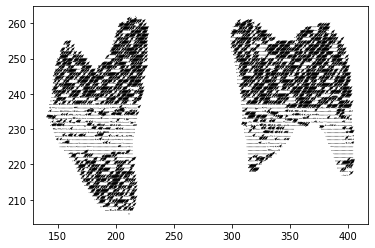

In [18]:
roi_cord = np.argwhere(mask != 0)
x = []
y = []
for i in roi_cord.tolist():
    x.append(i[1])
    y.append(i[0])


u = []
v = []

for i in assd_mask:
    u.append(i[1])
    v.append(i[0])
u = np.array(u)
v = np.array(v)

fig,ax = plt.subplots()
ax.quiver(x, y, u, v)
#ax.quiverkey(q, X=0.3, Y=1.1, U=10,
             #label='Quiver key, length = 10', labelpos='E')
plt.show()


In [19]:
len(roi_cord)

6169

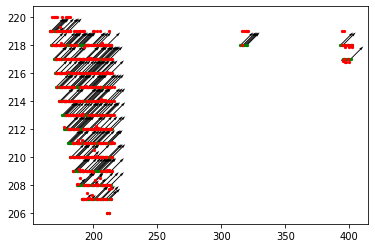

In [20]:
fig,ax = plt.subplots()
ax.quiver(x[:500], y[:500], u[:500], v[:500])
ax.scatter(x[:500], y[:500], color = "g", s=5)
ax.scatter(x[:500]+u[:500], y[:500]+v[:500], color = "r", s=5)
plt.show()

In [21]:
DU_mask = np.zeros((512,512))
x_new = x + u
y_new = y + v
for i in range(len(x_new)-1):
    DU_mask[int(round(y_new[i], 0)), int(round(x_new[i], 0))] = 1
    DU_mask[int(y[i]), int(x[i])] = 1

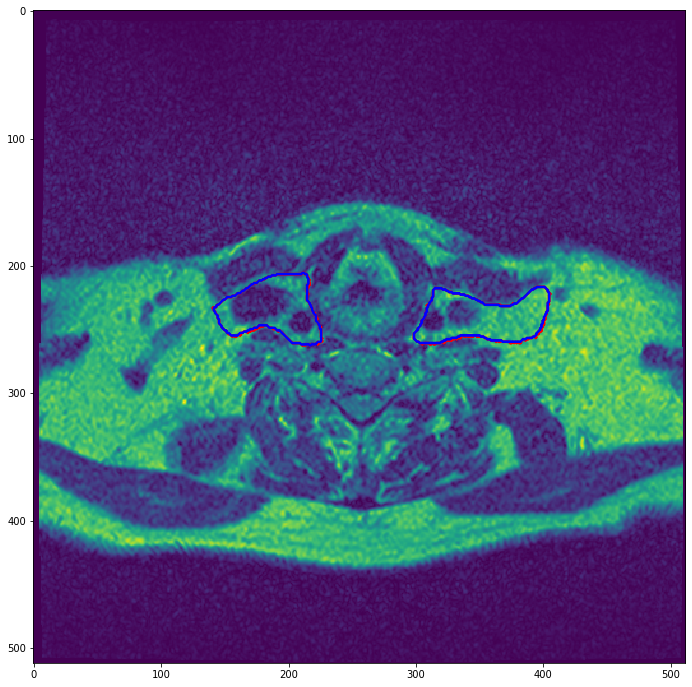

In [22]:
fig,ax = plt.subplots(1,1,figsize=[12,12])
plt.imshow(target_img)
#ax.scatter(x_new, y_new, color="r", s=2)
ax.contour(DU_mask, colors="red")
ax.contour(mask, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")
#ax.quiverkey(q, X=0.3, Y=1.1, U=10,
             #label='Quiver key, length = 10', labelpos='E')
plt.show()